In [2]:
import pandas as pd
import numpy as np

### Load data from json

In [3]:
import glob
import json
from datetime import datetime

In [155]:
path = glob.glob('*/*.json')
df_dict = {}
df_list = []

for f in path :
    raw_json = open(f,'r')
    raw_json = json.load(raw_json)
    try :
        df_dict[raw_json['currency']].extend(raw_json['completeOrders'])
    except :
        df_dict[raw_json['currency']] = raw_json['completeOrders']

for value in df_dict.values() :
    df_tmp = pd.DataFrame(value).apply(pd.to_numeric)
    df_tmp['timestamp'] = df_tmp['timestamp'].apply(lambda x: datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M'))
    df_tmp = pd.DataFrame([df_tmp.groupby('timestamp')['price'].mean(), df_tmp.groupby('timestamp')['qty'].sum()]).T
    df_list.append(df_tmp)

df = pd.concat(df_list, axis=1)
start_time = df.index[0]
end_time = df.index[-1]
df = df.reindex(pd.date_range(start_time, end_time, freq='1min').strftime('%Y-%m-%d %H:%M'))
df['price']= df['price'].fillna(method='ffill')
df['qty']= df['qty'].fillna(0)
df = df.dropna()

### Modify data for training

In [222]:
window = 60
error = 1e-3

batch_num = int(len(df)/window)
window_num = int(24*60/window)
data = np.array(np.split(np.array(df.iloc[:len(df)-len(df)%window]), batch_num))
prc = np.array([np.amax(d, axis=0) for d in data])[:,::2] + error
qty = np.array([np.amax(d, axis=0) for d in data])[:,1::2] + error
data[:,:,::2] = data[:,:,::2] / prc[:,None,:]
data[:,:,1::2] = data[:,:,1::2] / qty[:,None,:]

X = []
for i in range(batch_num-window_num) :
    X.append(data[i:i+window_num])
X = np.array(X).reshape(batch_num-window_num, 24*60, data.shape[-1])
Y = prc[window_num:window_num+X.shape[0]] / prc[:X.shape[0]]

### LSTM model from keras

In [257]:
from keras.models import Sequential
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error

dropout = 0
validation = 0.33
epochs = 100

In [258]:
model = Sequential()
model.add(LSTM(Y.shape[1], batch_input_shape=(1,X.shape[1], X.shape[2]), stateful=True, dropout=dropout, recurrent_dropout=dropout, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(X, Y, epochs=epochs, batch_size=1, verbose=2, validation_split=validation)

Train on 22 samples, validate on 11 samples
Epoch 1/100
17s - loss: 1.0344 - val_loss: 0.8135
Epoch 2/100
14s - loss: 0.8075 - val_loss: 0.6236
Epoch 3/100
14s - loss: 0.6370 - val_loss: 0.4865
Epoch 4/100
14s - loss: 0.4817 - val_loss: 0.3688
Epoch 5/100
14s - loss: 0.3711 - val_loss: 0.3222
Epoch 6/100
14s - loss: 0.3259 - val_loss: 0.2845
Epoch 7/100
15s - loss: 0.2920 - val_loss: 0.2554
Epoch 8/100
14s - loss: 0.2469 - val_loss: 0.2027
Epoch 9/100
15s - loss: 0.1861 - val_loss: 0.1544
Epoch 10/100
14s - loss: 0.1475 - val_loss: 0.1301
Epoch 11/100
14s - loss: 0.1227 - val_loss: 0.1024
Epoch 12/100
14s - loss: 0.0748 - val_loss: 0.0480
Epoch 13/100
14s - loss: 0.0200 - val_loss: 0.0144
Epoch 14/100
15s - loss: 0.0103 - val_loss: 0.0189
Epoch 15/100
14s - loss: 0.0110 - val_loss: 0.0128
Epoch 16/100
14s - loss: 0.0070 - val_loss: 0.0133
Epoch 17/100
14s - loss: 0.0066 - val_loss: 0.0126
Epoch 18/100
14s - loss: 0.0052 - val_loss: 0.0133
Epoch 19/100
14s - loss: 0.0055 - val_loss: 0.0

### Plot loss for training and validation

In [259]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_palette(sns.color_palette('deep'))

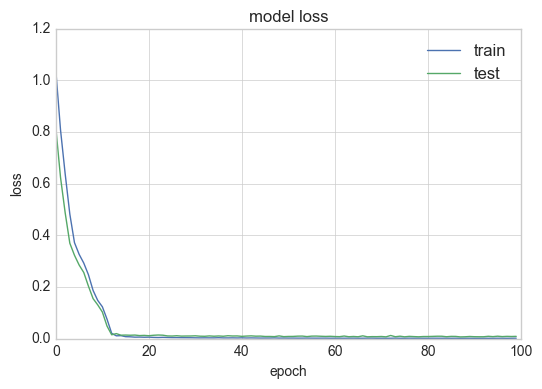

In [260]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

### Compare predicted / real data

In [261]:
Y_predict = np.array([model.predict(x.reshape(1,x.shape[0], x.shape[1])) for x in X])
Y_predict = Y_predict.reshape((Y_predict.shape[0], Y_predict.shape[2])) * prc[:X.shape[0]]
Y_real = Y * prc[:X.shape[0]]

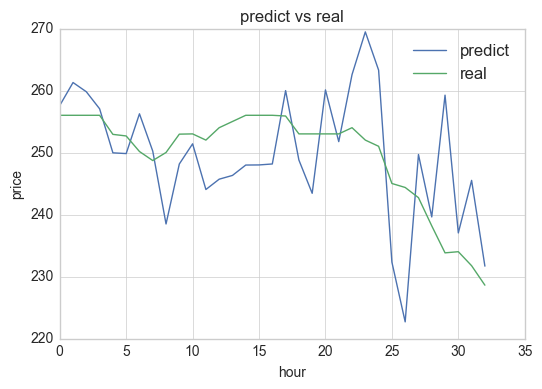

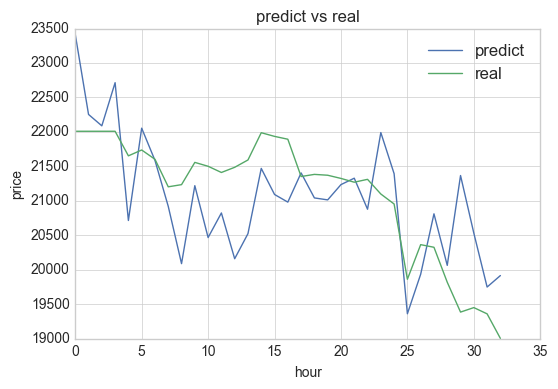

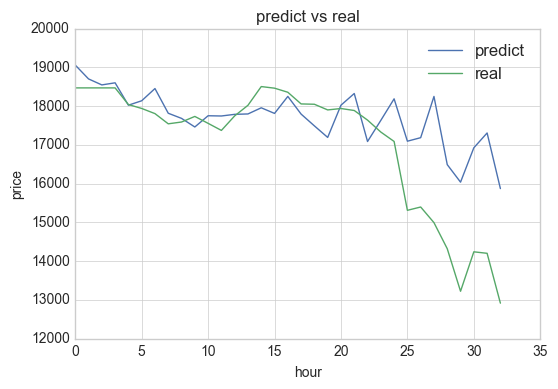

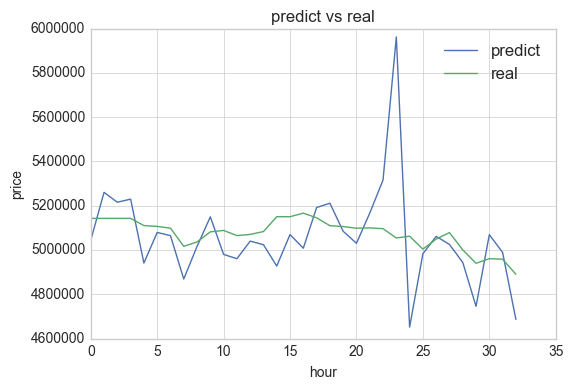

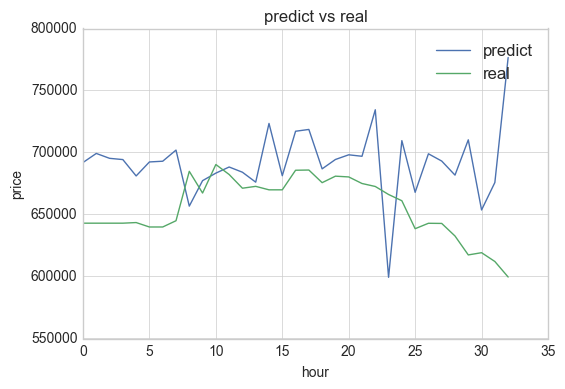

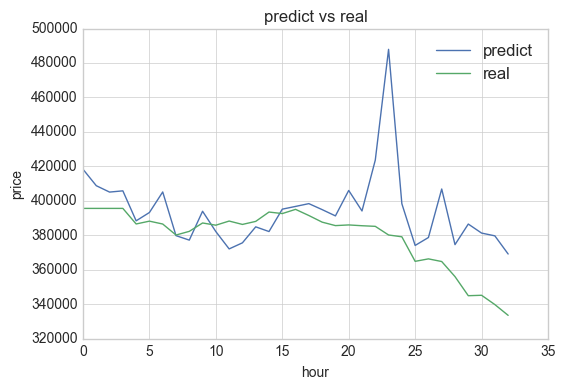

In [262]:
for i in range(len(Y.T)) :
    plt.plot(Y_predict[:,i])
    plt.plot(Y_real[:,i])
    plt.title('predict vs real')
    plt.ylabel('price')
    plt.xlabel('hour')
    plt.legend(['predict', 'real'], loc='upper right')
    plt.show()